In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as DT

sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_style("white")
sys.path.append("..")
import rbf_functions

In [3]:
rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

# Load model data for each activation function

In [ ]:
nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes
            #             selected_nfe = u_nfes[0::5]
            #             selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[
                archives_by_nfe["Unnamed: 0"].isin(selected_nfe)
            ]

# Transform the dataframe back into platypus solution instances, to have a collection of solutions for each generation

In [3]:
from platypus import Solution, Problem, EpsilonIndicator

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]:  # nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive

# load refsets for each rbf, turn into solutions sets

In [ ]:
ref_dir = "../refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f"{ref_dir}{name}_refset.csv")
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

# Or, load global refset for all rbfs, turn into solution set

In [4]:
ref_dir = "./refsets"
data = pd.read_csv(f"{ref_dir}/global_refset.csv")
ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)

In [24]:
archives.keys()

dict_keys(['original_rbf', 'squared_exponential_rbf', 'inverse_quadratic_rbf', 'inverse_multiquadric_rbf', 'exponential_rbf', 'matern32_rbf', 'matern52_rbf'])

# Calculate Additive epsilon Indicator for each activation function and each seed

In [5]:
# ei = EpsilonIndicator(reference_set=ref_set)
# nfes = []
# eis = []
# for nfe, archive in archives.items():
#     nfes.append(nfe)
#     eis.append(ei.calculate(archive))

# rbf = "inverse_multiquadric_rbf"
tempnfe = {}
tempei = {}
nfe_sets = {}
ei_sets = {}
for rbf in archives:
    nfe_sets[rbf] = {}
    ei_sets[rbf] = {}
    #     ei = EpsilonIndicator(reference_set=ref_sets[rbf])
    ei = EpsilonIndicator(reference_set=ref_set)  # global refset
    print(f"started {rbf} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        ei_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        eis = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            eis.append(ei.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        ei_sets[rbf][seed] = eis
        tempnfe[seed] = nfes
        tempei[seed] = eis
        dfei = pd.DataFrame.from_dict(tempei, orient="index")
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient="index")
        dfei = dfei.T
        dfnfe = dfnfe.T
        #         dfei.to_csv(f"epind/{rbf}_ei.csv", index=False) #local refset
        #         dfnfe.to_csv(f"epind/{rbf}_ei_nfe.csv", index=False) #local refset
        dfei.to_csv(f"epind_global/{rbf}_ei_all.csv", index=False)  # global
        dfnfe.to_csv(f"epind_global/{rbf}_ei_nfe_all.csv", index=False)  # global
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started original_rbf at 11:15:47
finished seed: 10 at 11:19:12
finished seed: 20 at 11:21:59
finished seed: 30 at 11:25:54
finished seed: 40 at 11:29:50
finished seed: 50 at 11:32:55
finished seed: 60 at 11:36:35
finished seed: 70 at 11:39:48
finished seed: 80 at 11:42:25
finished seed: 90 at 11:46:05
finished seed: 100 at 11:49:57
started squared_exponential_rbf at 11:49:58
finished seed: 10 at 11:52:33
finished seed: 20 at 11:56:20
finished seed: 30 at 11:58:17
finished seed: 40 at 12:01:21
finished seed: 50 at 12:04:32
finished seed: 60 at 12:08:14
finished seed: 70 at 12:12:31
finished seed: 80 at 12:15:33
finished seed: 90 at 12:18:33
finished seed: 100 at 12:21:11
started inverse_quadratic_rbf at 12:21:11
finished seed: 10 at 12:23:30
finished seed: 20 at 12:25:19
finished seed: 30 at 12:27:40
finished seed: 40 at 12:30:11
finished seed: 50 at 12:31:55
finished seed: 60 at 12:33:51
finished seed: 70 at 12:36:48
finished seed: 80 at 12:39:14
finished seed: 90 at 12:41:45
finished 

# Plot results

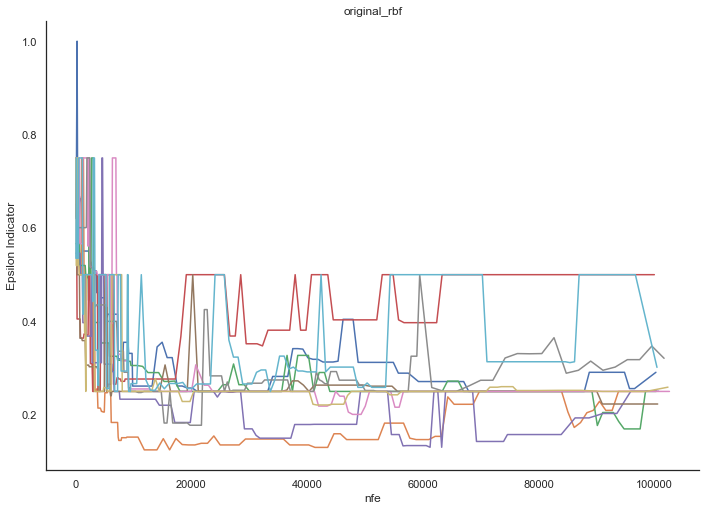

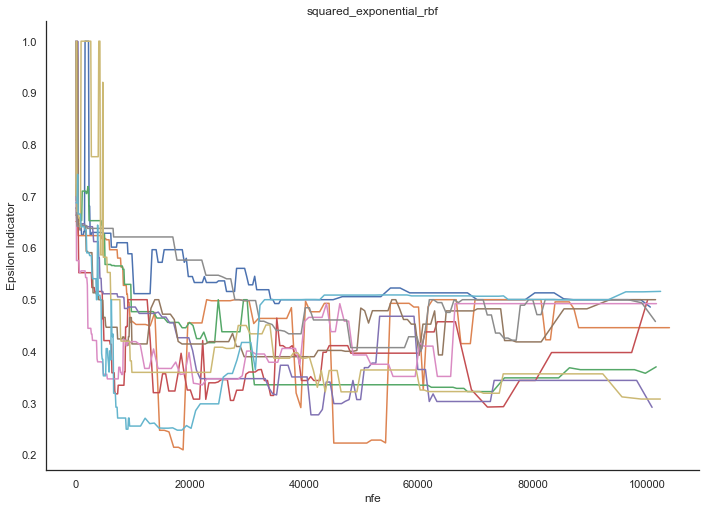

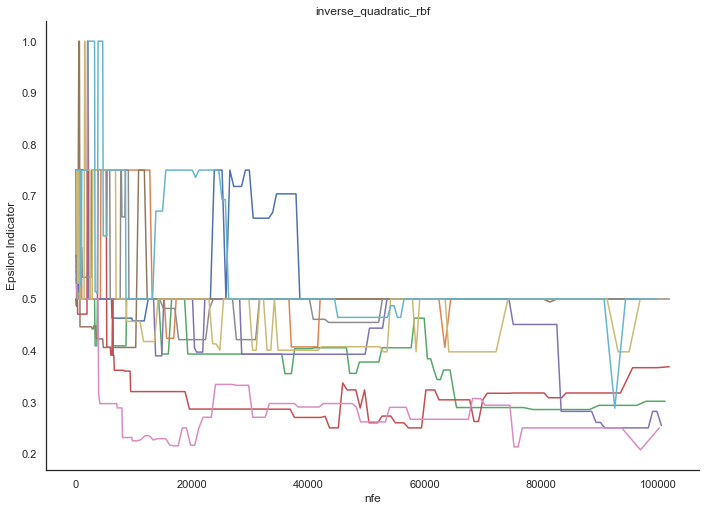

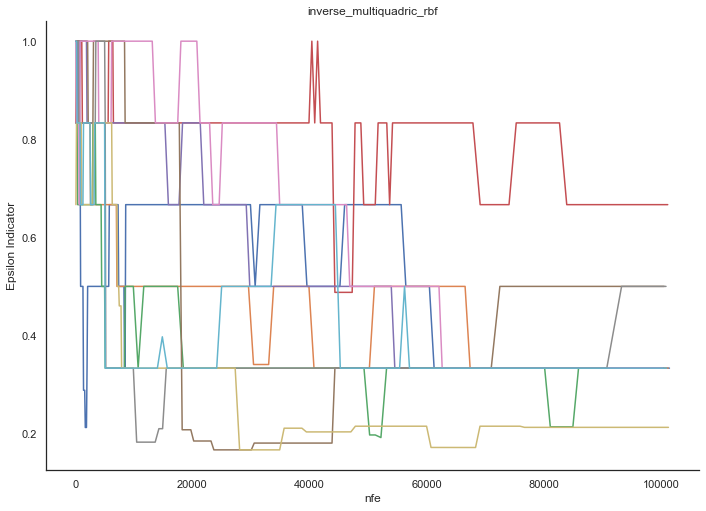

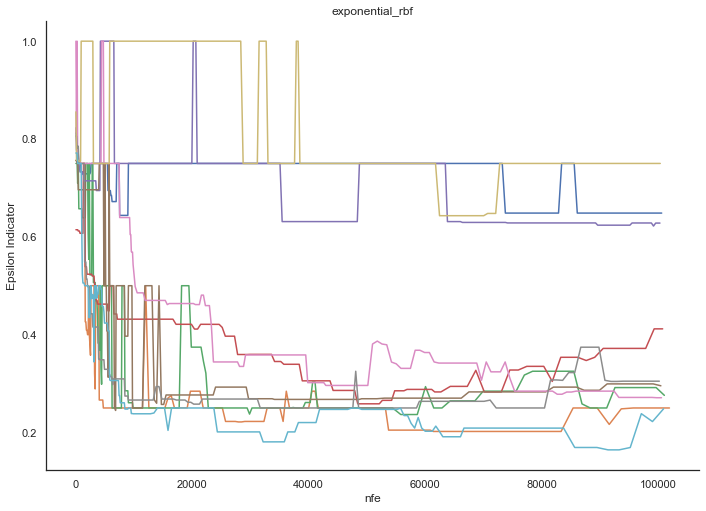

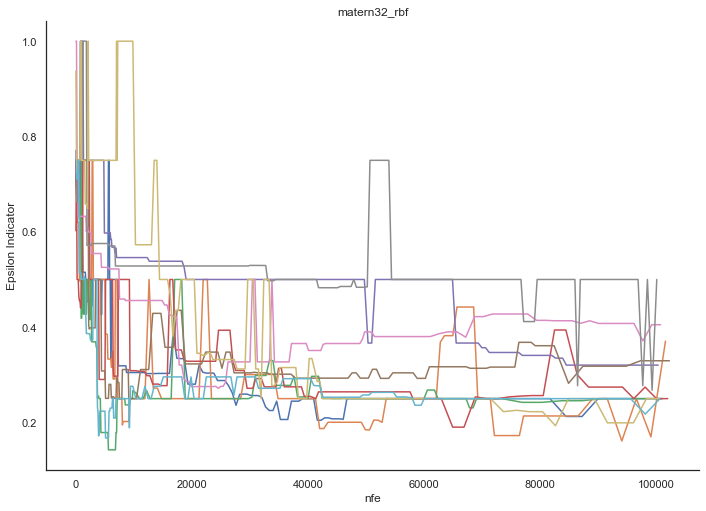

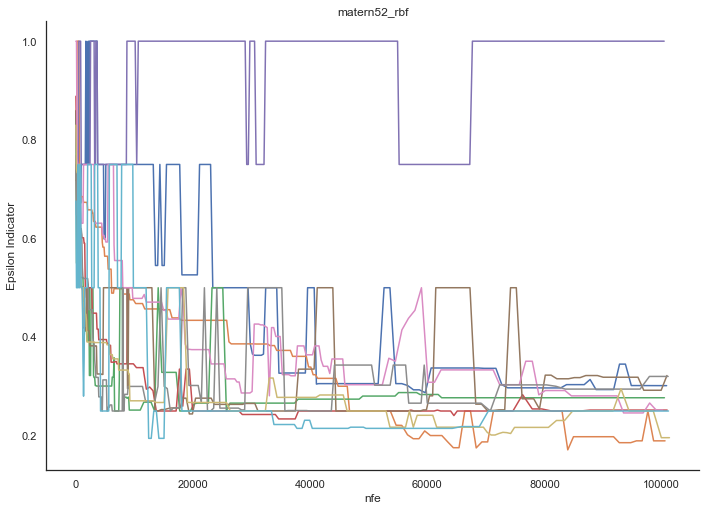

In [49]:
sns.set_style("white")
for entry in rbfs:
    name = entry.__name__
    ei = pd.DataFrame.from_dict(ei_sets[name], orient="index").T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient="index").T

    fig, ax = plt.subplots()
    ax.plot(nfe, ei)
    ax.set_xlabel("nfe")
    ax.set_ylabel("Epsilon Indicator")
    ax.set_title(name)
    sns.despine()

    plt.show()

# Local reference set

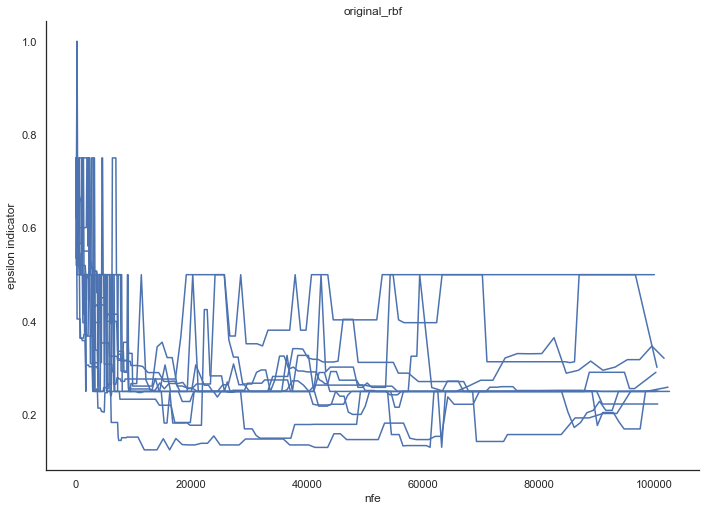

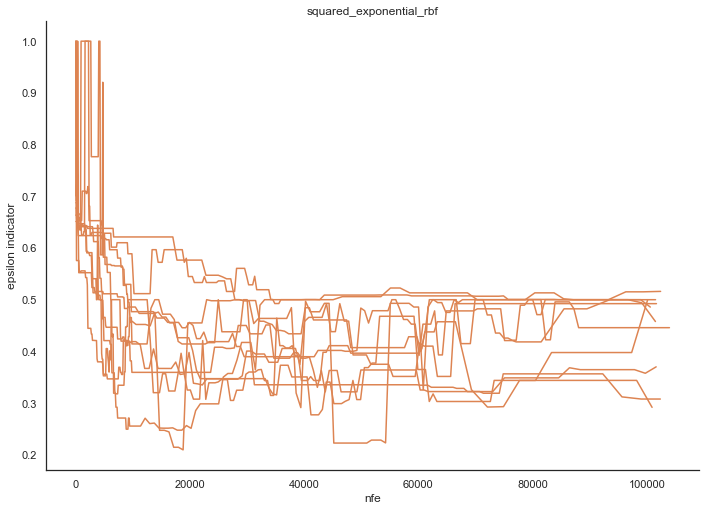

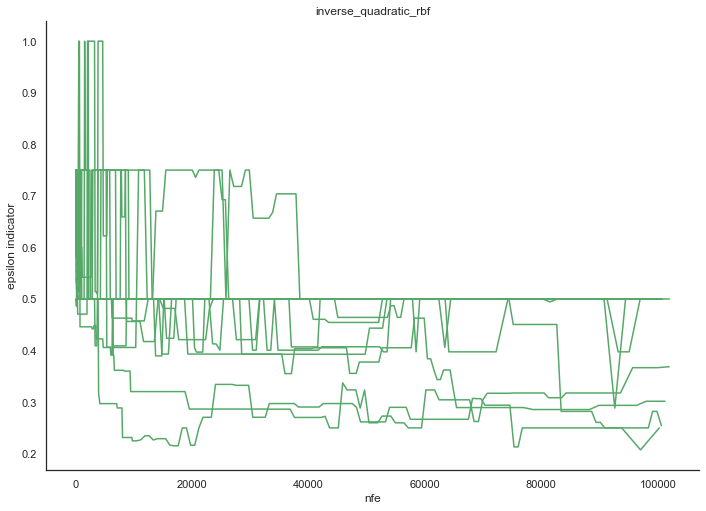

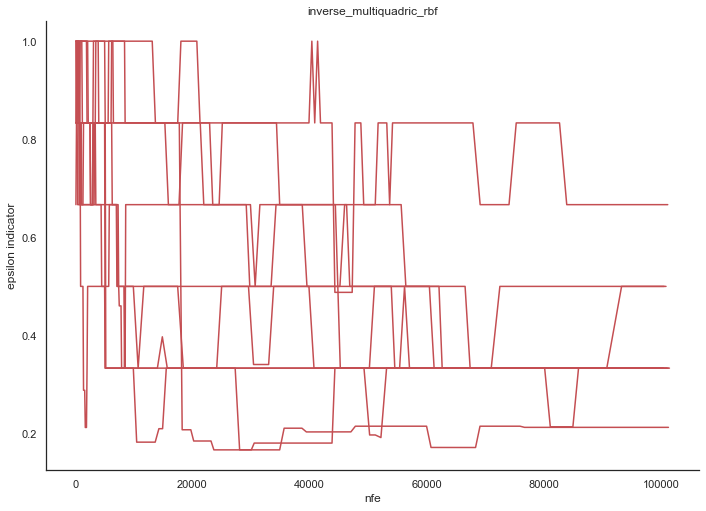

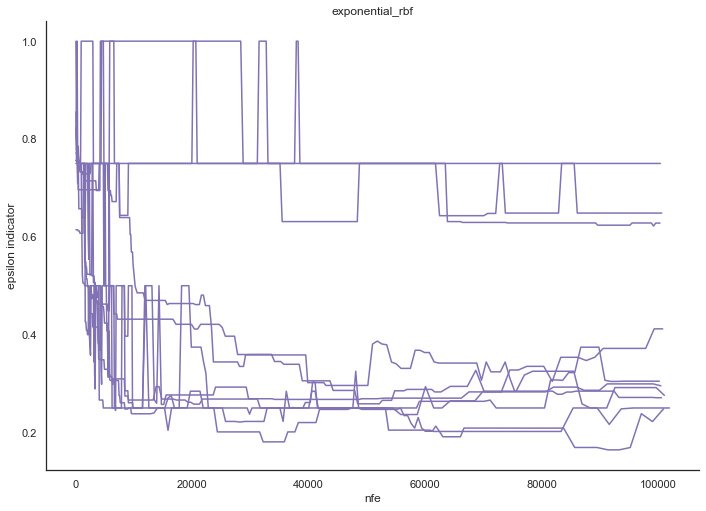

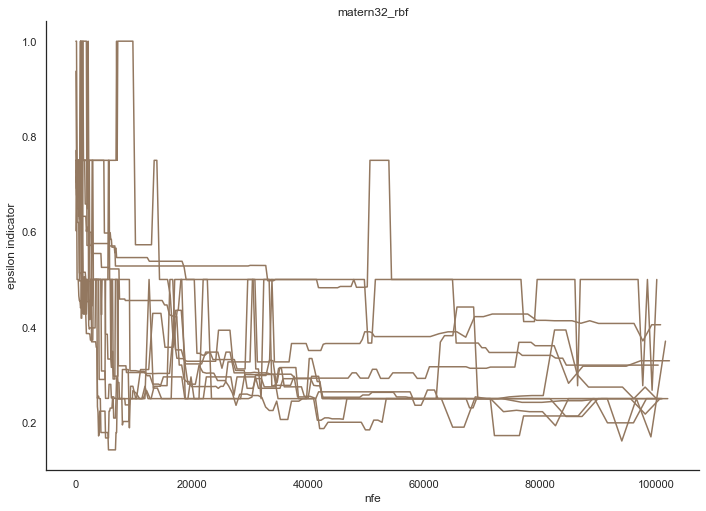

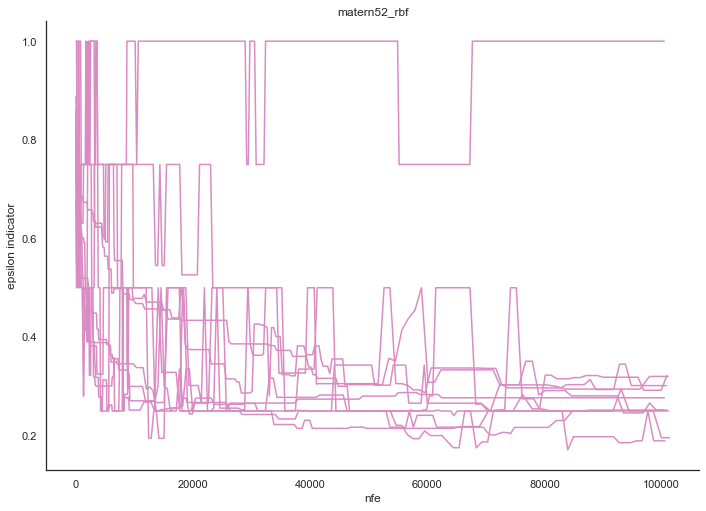

In [8]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_ei = pd.read_csv(f"epind/{rbf}_ei.csv")
    df_ei_nfe = pd.read_csv(f"epind/{rbf}_ei_nfe.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_ei_nfe, df_ei, color=c)

    ax.set_xlabel("nfe")
    ax.set_ylabel("epsilon indicator")
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f"figs/{rbf}/{rbf}_ei.png")
plt.show()

# Global reference set

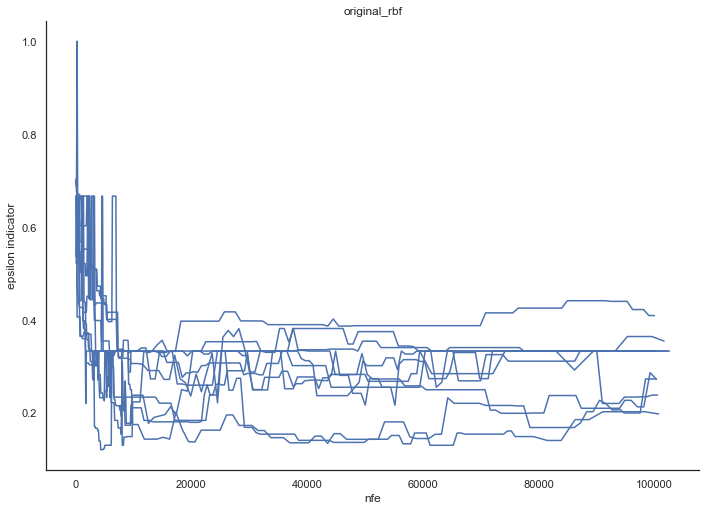

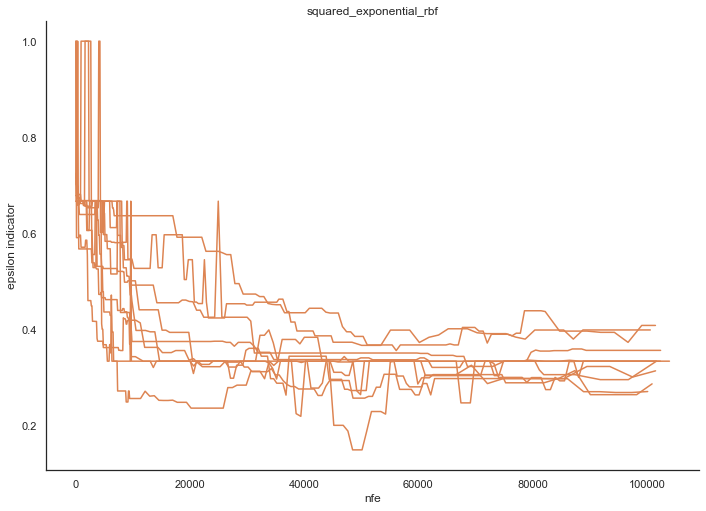

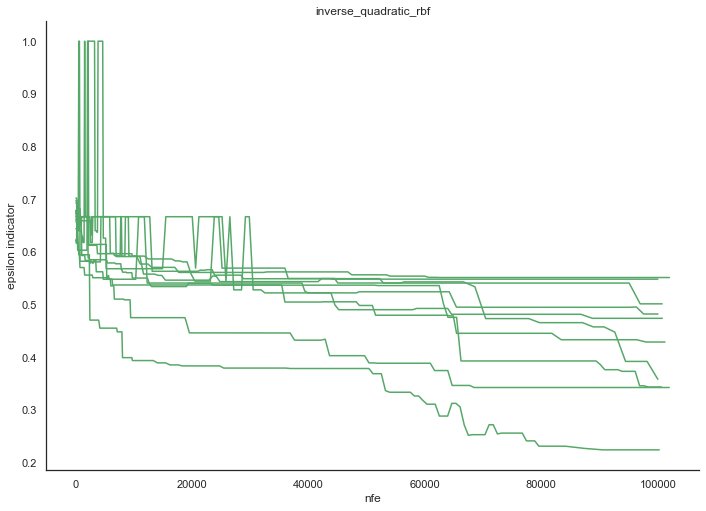

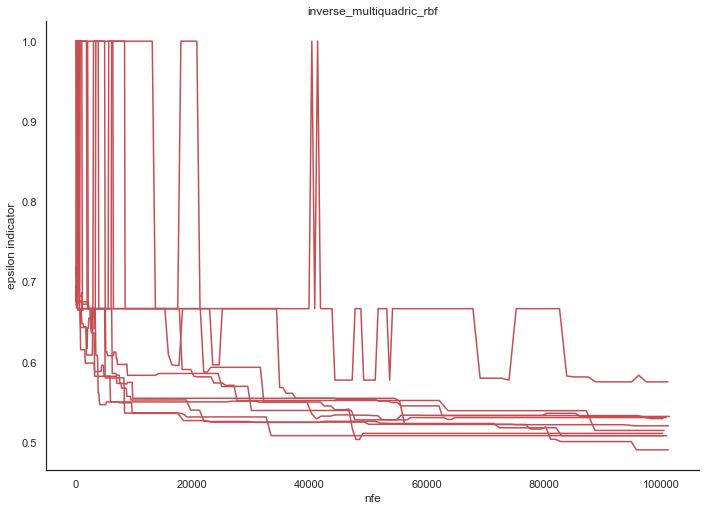

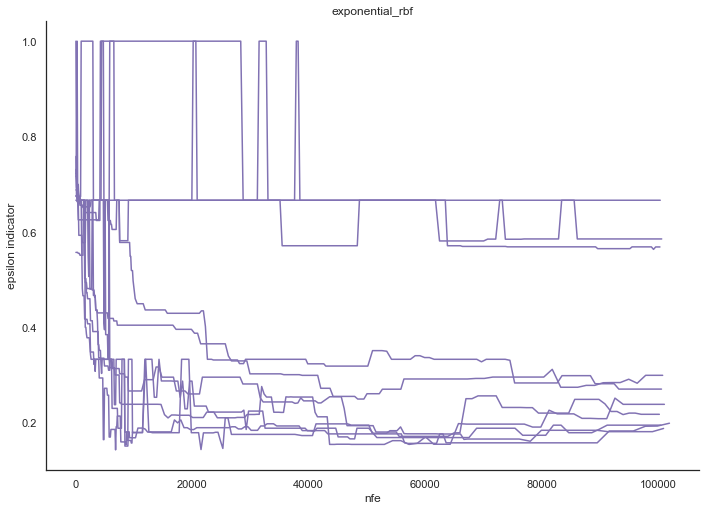

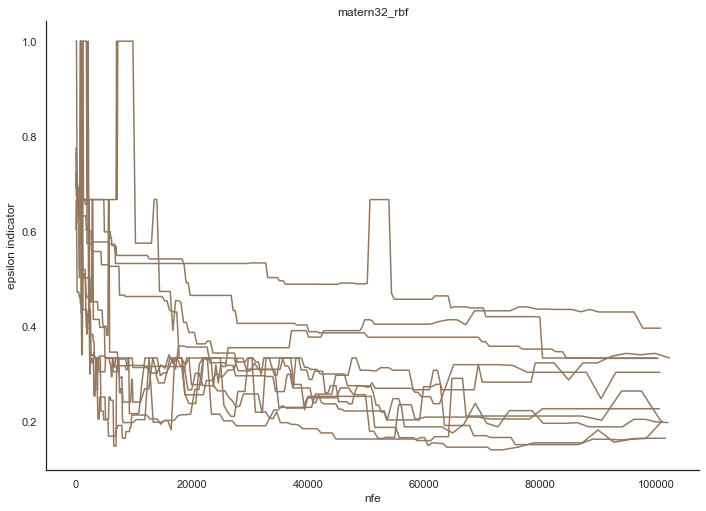

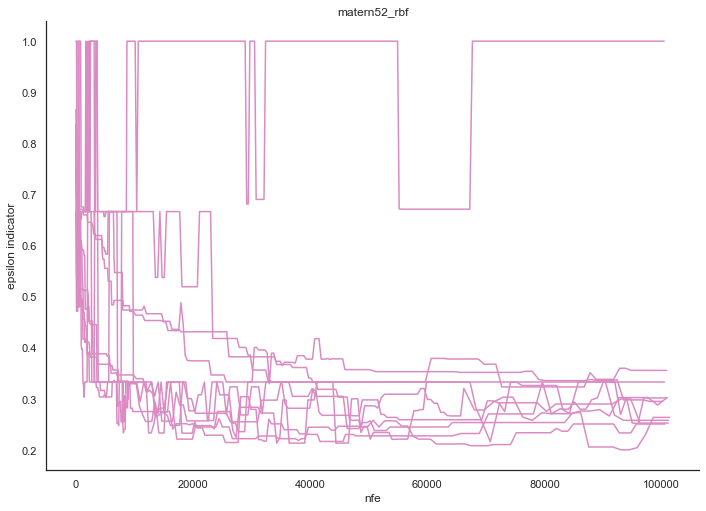

In [5]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_ei = pd.read_csv(f"epind_global/{rbf}_ei_all.csv")
    df_ei_nfe = pd.read_csv(f"epind_global/{rbf}_ei_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_ei_nfe, df_ei, color=c)

    ax.set_xlabel("nfe")
    ax.set_ylabel("epsilon indicator")
    ax.set_title(rbf)
    sns.despine()
#     plt.savefig(f'figs/{rbf}/{rbf}_ei_global.png')
plt.show()